## MNIST GAN with style:
GAN training of a style generator and resblock discriminator on MNIST data. Frechet Distance scores from a basic classifier are used as a metric. R1 regularization is used to help with training.

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.autograd import grad
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from tqdm.notebook import tqdm
from scipy.linalg import sqrtm

In [95]:
ROOT = Path.cwd() / "data" / "mnist"

In [96]:
X_train = np.load(ROOT / "X_train.npy")
X_test = np.load(ROOT / "X_test.npy")
xmean = 0.5
xstd = 0.5
X_train = (X_train - xmean) / xstd
X_test = (X_test - xmean) / xstd
y_train = np.load(ROOT / "y_train.npy")
y_test = np.load(ROOT / "y_test.npy")

In [97]:
X = torch.ones((len(X_train), 1, 32, 32)) * -1
X[:, :, 2:-2, 2:-2] = torch.from_numpy(X_train).view(-1, 1, 28, 28)
Xt = torch.ones((len(X_test), 1, 32, 32)) * -1
Xt[:, :, 2:-2, 2:-2] = torch.from_numpy(X_test).view(-1, 1, 28, 28)
y = torch.from_numpy(y_train)
yt = torch.from_numpy(y_test)

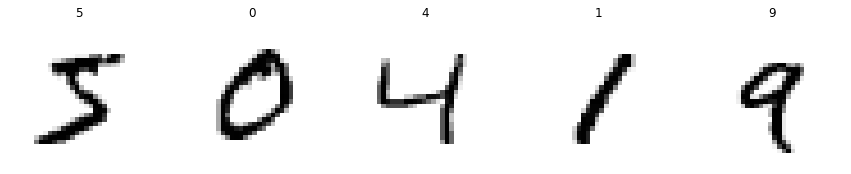

In [98]:
fig, axs = plt.subplots(1, 5, figsize=(15, 8))
for i in range(5):
    im = X[i, 0].detach().numpy()
    axs[i].imshow(im, cmap="gray_r")
    axs[i].title.set_text(y[i].item())
    axs[i].axis('off')
plt.show()

In [99]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=3, stride=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1),
            nn.MaxPool2d(4),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.fc = nn.Linear(16, 10)
        
    def forward(self, x):
        return self.fc(self.convs(x))

In [100]:
class FD:
    """Adapted from https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/."""
    def __init__(self, classifier, X):
        self.classifier = classifier
        self.m, self.sigma = self.get_stats(X)
        
    def get_stats(self, X):
        act = self.classifier.convs(X)
        act = act.detach().numpy()
        m = np.mean(act, axis=0)
        sigma = np.cov(act, rowvar=False)
        return m, sigma
        
    def __call__(self, X):
        m, sigma = self.get_stats(X)
        ssdiff = ((self.m - m)**2.0).sum()
        covmean = sqrtm(self.sigma.dot(sigma))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fd = ssdiff + np.trace(self.sigma + sigma - 2.0 * covmean)
        return fd 

In [101]:
cls = Classifier()
opt = optim.Adam(cls.parameters(), lr=0.001, weight_decay=0.00001)
crit = nn.CrossEntropyLoss()

In [102]:
cls_trainset = DataLoader(TensorDataset(X, y), batch_size=64, shuffle=True)
cls_testset = DataLoader(TensorDataset(Xt, yt), batch_size=64, shuffle=True)

In [103]:
def cls_acc(preds, labels):
    size = len(preds)
    p = torch.argmax(preds, axis=1)
    correct = (p == labels).sum().item()
    return correct / size

In [104]:
def train_cls_fd(cls, cls_trainset, cls_testset):
    for epoch in range(10):
        accs = []
        for x, y in cls_trainset:
            preds = cls(x)
            loss = crit(preds, y)
            acc = cls_acc(preds, y)
            accs.append(acc)
            opt.zero_grad()
            loss.backward()
            opt.step()
        with torch.no_grad():
            accs = []
            for x, y in cls_testset:
                preds = cls(x)
                acc = cls_acc(preds, y)
                accs.append(acc)
        print(f"Epoch: {epoch + 1}, Acc: {np.mean(accs):.5f}")

In [105]:
train_cls_fd(cls, cls_trainset, cls_testset)

Epoch: 1, Acc: 0.88671
Epoch: 2, Acc: 0.92407
Epoch: 3, Acc: 0.93687
Epoch: 4, Acc: 0.94363
Epoch: 5, Acc: 0.94859
Epoch: 6, Acc: 0.95399
Epoch: 7, Acc: 0.95549
Epoch: 8, Acc: 0.95945
Epoch: 9, Acc: 0.96212
Epoch: 10, Acc: 0.96415


In [124]:
for p in cls.parameters():
    p.requires_grad = False
fd = FD(cls, X)
fd(Xt), fd(torch.randn(1, 1, 32, 32))

(-7.753797603982093e-13, 3133.2193855795504)

In [125]:
class LatentZ(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim
        
    def forward(self, labels):
        return torch.randn((len(labels), self.latent_dim))

In [126]:
class Generator(nn.Module):
    def __init__(self, latent_dim=3, size=8, img_size=32):
        super().__init__()
        self.latent = LatentZ(latent_dim)
        self.gen_block = GenBlock(latent_dim)
        self.gen_syn = GenSyn(latent_dim, size,  img_size // 4)
        
    def forward(self, labels, has_latent=False, latent=None):
        z_latent = latent if has_latent else self.latent(labels)
        w_latent = self.gen_block(z_latent)
        imgs = self.gen_syn(w_latent)
        return imgs

In [127]:
class GenBlock(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, latent_dim), 
            nn.LeakyReLU(negative_slope=0.2), 
            nn.Linear(latent_dim, latent_dim), 
            nn.LeakyReLU(negative_slope=0.2))
    
    def forward(self, z_latent):
        w_latent = self.net(z_latent)
        return w_latent

In [128]:
class GenSyn(nn.Module):
    def __init__(self, latent_dim, size=8, img_size=4):
        super().__init__()
        self.size = size
        self.const = Constant(size, img_size)
        self.upscale = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.blocks = nn.ModuleList()
        for i in range(5):
            upscale = bool(i % 2)
            self.blocks.append(GenSynBlock(latent_dim, size, upscale))
        self.sig = nn.Tanh()

    def forward(self, w_latent):
        combined_imgs = 0
        bs = len(w_latent)
        x = self.const(bs)
        for block in self.blocks:
            x, imgs = block(x, w_latent)
            if hasattr(imgs, "shape"):
                if hasattr(combined_imgs, "shape"):
                    combined_imgs = self.upscale(combined_imgs)
                combined_imgs += imgs
        return self.sig(combined_imgs)

In [129]:
class Constant(nn.Module):
    def __init__(self, size, img_size=4):
        super().__init__()
        self.const = nn.Parameter(torch.randn(1, size, img_size, img_size))

    def forward(self, bs):
        out = self.const.repeat(bs, 1, 1, 1)
        return out

In [130]:
class GenSynBlock(nn.Module):
    def __init__(self, latent_dim, size, upscale=True):
        super().__init__()
        self.size = size
        self.upscale = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False) if upscale else None
        self.style_lin = nn.Linear(latent_dim, size)
        self.noise_lin = nn.Linear(1, size)
        self.conv = nn.Conv2d(size, size, kernel_size=3, padding=1)
        self.norm = nn.InstanceNorm2d(size, eps=1e-08)
        self.act = nn.LeakyReLU(negative_slope=0.2)
        self.to_rgb = nn.Conv2d(size, 1, kernel_size=1, padding=0) if not(upscale) else None
        
    def forward(self, x, w_latent):
        # noise: bs x max_img_size ** 2
        # w_latent: bs x latent_dim
        if self.upscale:
            x = self.upscale(x)
        bs, ch, h, w = x.shape
        style = self.style_lin(w_latent)
        x = self.norm(self.conv(x) * style.view(bs, self.size, 1, 1))
        x = self.act(x) 
        if self.to_rgb:
            imgs = self.to_rgb(x)
        else:
            imgs = 0
        return x, imgs

In [151]:
class Discriminator(nn.Module):
    def __init__(self, size=4, n_blocks=3):
        super().__init__()
        layers = []
        c_in = 1
        c_out = size
        for layer in range(n_blocks):
            layers.append(nn.Conv2d(c_in, c_out, kernel_size=3, stride=2))
            if layer != 0:
                layers.append(nn.BatchNorm2d(c_out))
            layers.append(nn.LeakyReLU(0.2))
            c_in = c_out
            c_out = c_out * 2
        self.convs = nn.Sequential(*layers)
        with torch.no_grad():
            bs, c, h, w = self.convs(torch.randn(16, 1, 32, 32)).shape
        f_size = (c * h * w)
        self.flatten = nn.Flatten()
        self.head = nn.Sequential(nn.Linear(f_size, 4), nn.LeakyReLU(0.2), nn.Linear(4, 1), nn.Sigmoid())
        
    def forward(self, x, l):
        x = self.flatten(self.convs(x))
        return self.head(x)

In [152]:
def set_requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

Note : Discrim predicts probability image is real. Fake=0, True=1.

In [164]:
class DLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCELoss(reduction="none")
        
    def forward(self, true_preds, fake_preds):
        t_loss = self.loss(true_preds, torch.ones(len(true_preds), 1))
        f_loss = self.loss(fake_preds, torch.zeros(len(fake_preds), 1))
        return torch.cat((t_loss, f_loss), axis=0).mean()

In [165]:
class R1Pen(nn.Module):
    """Adpated from https://github.com/Yangyangii/GAN-Tutorial/blob/master/CelebA/R1GAN.ipynb"""
    def __init__(self, gamma=10):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, true_imgs, true_preds):
        grad_true = grad(outputs=true_preds.sum(), inputs=true_imgs, create_graph=True)[0]
        grad_penalty = (grad_true.view(grad_true.size(0), -1).norm(2, dim=1) ** 2).mean()
        return 0.5 * self.gamma * grad_penalty

In [166]:
class GLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCELoss()
        
    def forward(self, fake_preds):
        return self.loss(fake_preds, torch.ones(len(fake_preds), 1))

In [167]:
def accuracy(true_preds, fake_preds):
    t_acc = (true_preds >= 0.5).sum()
    f_acc = (fake_preds < 0.5).sum()
    return (t_acc + f_acc) / ( float(len(true_preds) + len(fake_preds)))

In [168]:
def train_epoch(loader, gen, discrim, g_crit, d_crit, g_opt, d_opt, fd, r1=None):
    d_losses = []
    d_accs = []
    g_losses = []
    f_preds = []
    t_preds = []
    fd_scores = []
    for (true_imgs, labels) in loader:
        gen.eval()
        discrim.train()
        d_loss, d_acc, fp, tp = train_discrim(true_imgs, labels, gen, discrim, d_crit, d_opt, r1)
        gen.train()
        g_loss, fd_score = train_gen(labels, gen, discrim, g_crit, g_opt, fd)
        d_losses.append(d_loss)
        d_accs.append(d_acc)
        f_preds.append(fp)
        t_preds.append(tp)
        g_losses.append(g_loss)
        fd_scores.append(fd_score)
    return d_losses, d_accs, g_losses, fd_scores, f_preds, t_preds

In [181]:
def train_discrim(true_imgs, labels, gen, discrim, d_crit, d_opt, r1=None):
    set_requires_grad(gen, False)
    set_requires_grad(discrim, True)
    if r1:
        true_imgs.requires_grad = True
    true_preds = discrim(true_imgs, labels)
    grad_penalty = 0
    if r1:
        grad_penalty = r1(true_imgs, true_preds)
    fake_imgs = gen(labels)
    fake_preds = discrim(fake_imgs, labels)
    dloss = d_crit(true_preds, fake_preds)
    loss = dloss + grad_penalty
    acc = accuracy(true_preds, fake_preds)
    d_opt.zero_grad()
    loss.backward()
    d_opt.step()
    return dloss.item(), acc.item(), fake_preds.mean().item(), true_preds.mean().item()

In [182]:
def train_gen(labels, gen, discrim, g_crit, g_opt, fd):
    set_requires_grad(gen, True)
    set_requires_grad(discrim, False)
    fake_imgs = gen(labels)
    fake_preds = discrim(fake_imgs, labels)
    loss = g_crit(fake_preds)
    g_opt.zero_grad()
    loss.backward()
    g_opt.step()
    fd_score = fd(fake_imgs)
    return loss.item(), fd_score

In [183]:
def moving_average(x, w=200):
    return np.convolve(x, np.ones(w), 'valid') / w

In [184]:
size=60000
batch_size = 64
train_set = DataLoader(TensorDataset(X[:size], y[:size]), batch_size=batch_size, shuffle=True) 

In [192]:
latent_dim = 32
img_size = 32
gen = Generator(latent_dim=latent_dim, size=16, img_size=img_size)
discrim = Discriminator(size=16)
g_crit = GLoss()
d_crit = DLoss()
r1 = R1Pen()
g_opt = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_opt = optim.Adam(discrim.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_sched  = optim.lr_scheduler.ReduceLROnPlateau(g_opt, mode='min', factor=0.1, patience=1, eps=1e-6, verbose=True)
d_sched  = optim.lr_scheduler.ReduceLROnPlateau(d_opt, mode='min', factor=0.1, patience=1, eps=1e-6, verbose=True)

In [193]:
fds = []
dlosses = []
glosses = []
fps = []
tps = []
print("Epoch   DLoss   Dacc  Gloss    Gfd     FP     TP")
for i in range(15):
    dloss, dacc, gloss, fd_score, fp, tp = train_epoch(train_set, gen, discrim, g_crit, d_crit, g_opt, d_opt, fd, r1)
    print(f"{i+1}:     {np.mean(dloss):.4f}  {np.mean(dacc):.3f}  {np.mean(gloss):.4f}  {np.mean(fd_score):.2f}  {np.mean(fp):.3f}  {np.mean(tp):.3f}")
    fsched = torch.mean(torch.tensor(fd_score))
    g_sched.step(fsched)
    d_sched.step(fsched)
    fds += fd_score
    dlosses += dloss
    glosses += gloss
    fps += fp
    tps += tp

Epoch   DLoss   Dacc  Gloss    Gfd     FP     TP
1:     0.4414  0.766  0.7780  193.23  0.493  0.859
2:     0.5842  0.779  0.7406  38.81  0.486  0.622
3:     0.6173  0.796  0.7749  32.01  0.466  0.549
4:     0.6308  0.756  0.7675  28.95  0.470  0.539
5:     0.6415  0.720  0.7620  29.23  0.474  0.532
6:     0.6445  0.711  0.7596  27.99  0.475  0.530
7:     0.6438  0.703  0.7612  28.49  0.475  0.531
8:     0.6440  0.699  0.7629  28.15  0.474  0.530
Epoch     8: reducing learning rate of group 0 to 2.0000e-05.
Epoch     8: reducing learning rate of group 0 to 2.0000e-05.
9:     0.6459  0.735  0.7450  21.42  0.477  0.529
10:     0.6482  0.742  0.7419  20.13  0.477  0.526
11:     0.6475  0.740  0.7427  20.13  0.477  0.527
12:     0.6469  0.742  0.7421  20.44  0.477  0.527
Epoch    12: reducing learning rate of group 0 to 2.0000e-06.
Epoch    12: reducing learning rate of group 0 to 2.0000e-06.
13:     0.6477  0.742  0.7428  20.17  0.477  0.526
14:     0.6477  0.742  0.7438  20.37  0.477  0.5

In [ ]:
#latent 32, size 16
#Epoch   DLoss   Dacc  Gloss    Gfd     FP     TP
#1:     0.5778  0.892  0.9340  165.01  0.407  0.609
#2:     0.6005  0.858  0.8642  36.35  0.435  0.615
#3:     0.6164  0.827  0.8446  27.99  0.443  0.597
#4:     0.6306  0.797  0.8263  24.72  0.450  0.578
#5:     0.6397  0.779  0.8127  23.35  0.455  0.568

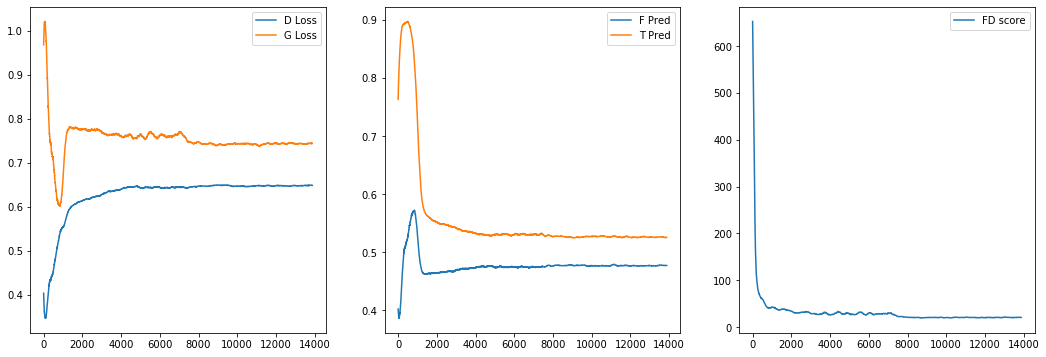

In [194]:
fds = moving_average(fds, w=200)
dlosses = moving_average(dlosses, w=200)
glosses = moving_average(glosses, w=200)
fps = moving_average(fps, w=200)
tps = moving_average(tps, w=200)

fig, ax = plt.subplots(1,3, figsize=(18, 6))
ax[0].plot(dlosses, label="D Loss")
ax[0].plot(glosses, label="G Loss")
ax[0].legend()
ax[1].plot(fps, label="F Pred")
ax[1].plot(tps, label="T Pred")
ax[1].legend()
ax[2].plot(fds, label="FD score")
ax[2].legend()
plt.show()

In [213]:
def show_examples(gen, dl):
    labels = torch.zeros(100)
    gen.eval()
    with torch.no_grad():
        fake_imgs = gen(labels)
    fig, axs = plt.subplots(5, 20, figsize=(15, 5))
    i = 0
    for row in axs:
        for col in row:
            col.imshow(fake_imgs[i,0].detach().numpy(),  cmap="gray_r")
            col.axis('off')
            i += 1
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('mnist_styled.png')
    plt.show()

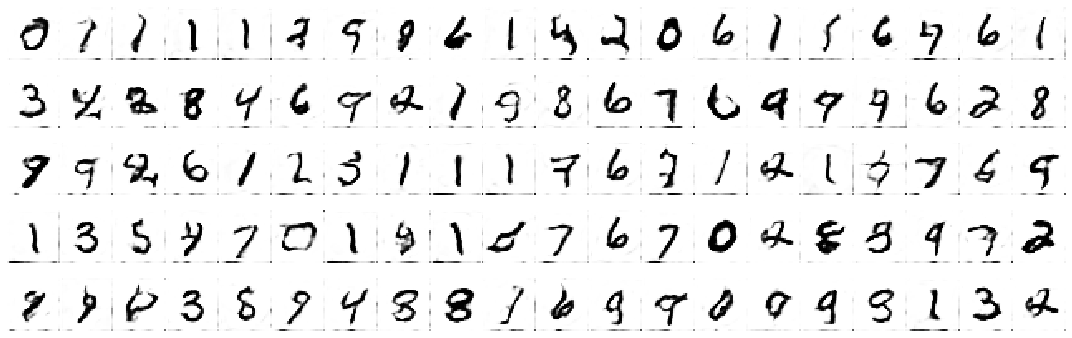

In [214]:
show_examples(gen, train_set)